# Imports

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1408

# Defining paths

In [ ]:
#trainfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/train.csv")
#testfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/test.csv")

In [ ]:
trainfilepath = ("./VideosSorted/train.csv")
testfilepath = ("./VideosSorted/test.csv")

In [ ]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 735
Total videos for testing: 326


,video_name,tag
1,drowning2.avi,drowning
474,v_Rafting_g24_c01.avi,rafting
539,v_Rowing_g14_c03.avi,rowing
386,v_Kayaking_g20_c01.avi,kayaking
618,v_Skijet_g15_c02.avi,jetski
318,v_Kayaking_g03_c02.avi,kayaking
468,v_Rafting_g21_c02.avi,rafting
62,v_BreastStroke_g09_c03.avi,breaststroke
640,v_Skijet_g23_c02.avi,jetski
266,v_FrontCrawl_g14_c04.avi,frontcrawl


# Data Pipeline

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    #feature_extractor = keras.applications.InceptionV3(
    feature_extractor = keras.applications.EfficientNetB2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
   # preprocess_input = keras.applications.inception_v3.preprocess_input
    preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['breaststroke', 'diving', 'drowning', 'frontcrawl', 'jetski', 'kayaking', 'notdrowning', 'rafting', 'rowing', 'surfing']


In [ ]:
trainrootdir = ("./VideosSorted/train")
testrootdir = ("./VideosSorted/test")

# Feature Extraction

In [ ]:
from tqdm import tqdm
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()


    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, trainrootdir)
test_data, test_labels = prepare_all_videos(test_df, testrootdir)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

735it [21:04,  1.72s/it]
326it [09:12,  1.70s/it]

Frame features in train set: (735, 20, 1408)
Frame masks in train set: (735, 20)


# GRU Model and Evaluation

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 150

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0)

Epoch 1/50
21/23 [==========================>...] - ETA: 0s - loss: 2.2436 - accuracy: 0.1652
Epoch 1: val_loss improved from inf to 2.09920, saving model to /tmp/video_classifier
23/23 [==============================] - 9s 107ms/step - loss: 2.2352 - accuracy: 0.1701 - val_loss: 2.0992 - val_accuracy: 0.2669
Epoch 2/50
21/23 [==========================>...] - ETA: 0s - loss: 2.0638 - accuracy: 0.2277
Epoch 2: val_loss improved from 2.09920 to 1.87147, saving model to /tmp/video_classifier
23/23 [==============================] - 0s 16ms/step - loss: 2.0524 - accuracy: 0.2340 - val_loss: 1.8715 - val_accuracy: 0.3558
Epoch 3/50
20/23 [=========================>....] - ETA: 0s - loss: 1.8666 - accuracy: 0.3516
Epoch 3: val_loss improved from 1.87147 to 1.67105, saving model to /tmp/video_classifier
23/23 [==============================] - 0s 16ms/step - loss: 1.8441 - accuracy: 0.3565 - val_loss: 1.6711 - val_accuracy: 0.5337
Epoch 4/50
20/23 [=========================>....] - ETA: 0s -

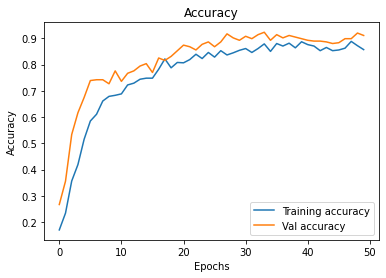

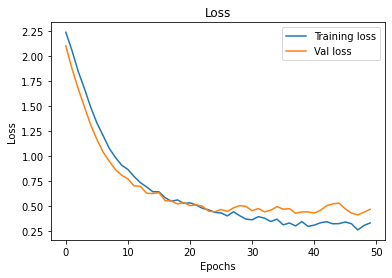

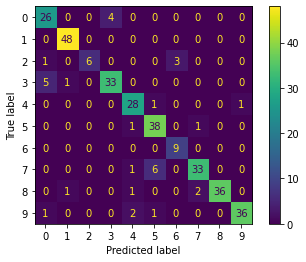

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")


    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    

    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Dense(20, activation="relu")(x)
    x = keras.layers.Dense(10, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        #validation_split=0.3,
        validation_data=([test_data[0], test_data[1]], test_labels),
        epochs=50,
        callbacks=[checkpoint, redcude_lr]
    )

   
   #Plot Graphs
    plt.figure(0)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    seq_model.summary()

    
    #Experiments Summary
    seq_model.load_weights(filepath)
    model_results = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(model_results[1] * 100, 2)}%")
    print("Test loss:" + str(model_results[0]))
    


    test_pred = seq_model.predict([test_data[0], test_data[1]])
    test_pred = list(np.argmax(test_pred,axis = 1))

   
    #Cohen's Kappa and F1 Score
    ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)

    print("Cohen's Kappa:"+str (cohen_kappa_score(test_labels, test_pred)))
    print(classification_report(test_labels, test_pred))

    return history, seq_model


_, sequence_model = run_experiment()